# Seguridad y Privacidad de los Datos - 2024/25

In [1]:
import os
import random
import copy
import time
import torch
import numpy as np
import pandas as pd
import onnxruntime as rt
import xgboost as xgb
import seaborn as sns
import matplotlib.pyplot as plt
from torch import nn
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

df = pd.read_csv('dataset.csv')
df = df.drop(["timestamp",'unused_permissions',"sha256"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(df.drop('label', axis=1), df['label'], test_size=0.1, random_state=42)

Using device: cuda


In [31]:
# from ydata_profiling import ProfileReport

# df = pd.read_csv('malware_dataset.csv')
# profile = ProfileReport(df, title='Malware Dataset Report')
# profile.to_file("malware_report.html")

# 0. Train the model on the provided dataset

## **XGBoost**

In [3]:
# params: https://xgboost.readthedocs.io/en/stable/python/python_api.html#xgboost.XGBClassifier
xgboost_model = xgb.XGBClassifier(objective='binary:logistic')

xgboost_model.fit(X_train, y_train)
y_pred = xgboost_model.predict(X_test)

print("Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

xgboost_model.save_model('malware_xgboost_model.json')

Accuracy:  0.9779528953426598
              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10145
           1       0.93      0.85      0.89      1149

    accuracy                           0.98     11294
   macro avg       0.96      0.92      0.94     11294
weighted avg       0.98      0.98      0.98     11294



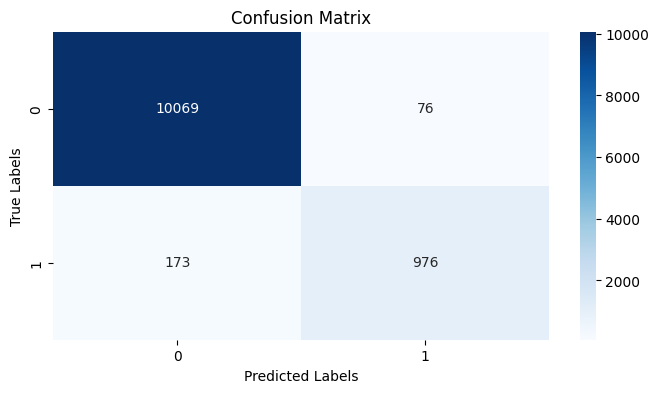

In [4]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [5]:
test_xgboost_model = xgb.XGBClassifier()
test_xgboost_model.load_model('malware_xgboost_model.json')

y_pred2 = xgboost_model.predict(X_test)
print("Accuracy: ", accuracy_score(y_test, y_pred2))

Accuracy:  0.9779528953426598


## **Neural Network**

In [4]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.fc1 = nn.Linear(354, 64)
        self.fc2 = nn.Linear(64, 2)
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x
class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return torch.tensor(self.data[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

In [7]:
model = Model().to(device)
dataloader_train = DataLoader(CustomDataset(X_train.values, y_train.values), batch_size=64, shuffle=True)
dataloader_test = DataLoader(CustomDataset(X_test.values, y_test.values), batch_size=64, shuffle=False)

EPOCHS = 10
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()
for epoch in range(EPOCHS):
    model.train()
    for data, labels in tqdm(dataloader_train, desc="Training", total=len(dataloader_train)):
        optimizer.zero_grad()
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    correct = 0
    total = 0
    for data, labels in tqdm(dataloader_test, desc="Testing", total=len(dataloader_test)):
        data, labels = data.to(device), labels.to(device)
        outputs = model(data)
        loss = criterion(outputs, labels)
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    print(f"Epoch {epoch+1}/{EPOCHS}, Accuracy: {100 * correct / total:.2f}%")

Testing: 100%|██████████| 118/118 [00:00<00:00, 327.11it/s]


Epoch 1/10, Accuracy: 95.90%


Testing: 100%|██████████| 118/118 [00:00<00:00, 328.60it/s]


Epoch 2/10, Accuracy: 95.58%


Testing: 100%|██████████| 118/118 [00:00<00:00, 373.41it/s]


Epoch 3/10, Accuracy: 96.28%


Testing: 100%|██████████| 118/118 [00:00<00:00, 323.59it/s]


Epoch 4/10, Accuracy: 96.39%


Testing: 100%|██████████| 118/118 [00:00<00:00, 539.93it/s]


Epoch 5/10, Accuracy: 96.53%


Testing: 100%|██████████| 118/118 [00:00<00:00, 568.56it/s]


Epoch 6/10, Accuracy: 96.63%


Testing: 100%|██████████| 118/118 [00:00<00:00, 531.85it/s]


Epoch 7/10, Accuracy: 96.60%


Testing: 100%|██████████| 118/118 [00:00<00:00, 521.30it/s]


Epoch 8/10, Accuracy: 96.61%


Testing: 100%|██████████| 118/118 [00:00<00:00, 551.16it/s]


Epoch 9/10, Accuracy: 96.67%


Testing: 100%|██████████| 118/118 [00:00<00:00, 497.03it/s]

Epoch 10/10, Accuracy: 96.98%


In [8]:
torch.save(model, 'malware_NN_model.pt')
model = torch.load('malware_NN_model.pt', weights_only=False)

# Test inference with a batch from the test dataloader
inputs, targets = next(iter(dataloader_test))
inputs = inputs.to(device)
outputs = model(inputs)
print(outputs.shape)

torch.Size([64, 2])


# 1. Perform at least one black-box attack and one white-box attack on the model. You may perform additional attacks as desired.

## Black box attack

In [13]:
test_xgboost_model = xgb.XGBClassifier()
test_xgboost_model.load_model('malware_xgboost_model.json')
x_no_attack = X_test[y_test == 0]
y_no_attack = y_test[y_test == 0]

ypred = test_xgboost_model.predict(np.array(x_no_attack))
ypred = [1 if x > 0.5 else 0 for x in ypred]
print(f"Accuracy: {accuracy_score(y_no_attack, ypred)}")

Accuracy: 0.9925086249383933


In [17]:
lista = []

for i in tqdm(range(1,2000), desc='Iterating over activities count'):
    no_attacks_changed = x_no_attack.copy()
    no_attacks_changed['activities_count'] = i
    ypred = test_xgboost_model.predict(np.array(x_no_attack))
    ypred = [1 if x > 0.5 else 0 for x in ypred]
    lista.append(accuracy_score(y_no_attack, ypred))

Iterating over activities count: 100%|██████████| 1999/1999 [01:14<00:00, 26.73it/s]


In [12]:
n_individuals = 100
n_generations = 10
mutation_rate = 0.1
population = np.random.randint(0, 2000, size=(n_individuals, 8))

class Genetic():
    def __init__(self, population_size: int, model, y_test, X_test):
        self.population = np.random.randint(0, 100, size=(population_size, 8)).tolist()
        self.fitnesses = []
        self.model = model
        self.y_test = y_test
        self.X_test = X_test

    def fitness(self, individual):
        test = self.X_test.copy()
        test[:,0] = individual[0]
        # test[:,1] = individual[1]
        # test[:,2] = individual[2]
        # test[:,3] = individual[3]
        test[:,4] = individual[4]
        test[:,5] = individual[5]
        test[:,6] = individual[6]
        # test[:,7] = individual[7]
        test = torch.tensor(test, dtype=torch.float32).to(device)
        predictions = self.model(test.to(device))
        predictions = torch.argmax(predictions, dim=1)
        predictions = predictions.cpu().numpy()
        return accuracy_score(self.y_test, predictions)

    def sort_pop(self, reversed: bool) -> tuple[list[list], list]:
        """Sort population by fitness function. Return tuple with population list and fitness list"""

        fitness_list = [self.fitness(ind) for ind in self.population]
        lista = sorted(zip(self.population, fitness_list), key=lambda x: x[1], reverse=reversed)
        self.population = [x[0] for x in lista]
        self.fitnesses = [x[1] for x in lista]

    def select(self, T: int) -> list:
        """Return a copy of an individual by tournament selection. Population already ordered by fitness"""
        
        indices = random.choices(range(len(self.population)), k=T)
        best_index = min(indices)  # since population is ordered by fitness
        return copy.deepcopy(self.population[best_index])

    def mutate(self,individual: list[list], pmut: float) -> list:
        """Mutate an individual, swap elements. Return mutated individual"""

        def mutate_swap(individual: list[list], pmut: float) -> list[list]:
            if random.random() < pmut:
                index1, index2 = random.choices(range(len(individual)), k=2)
                individual[index1], individual[index2] = individual[index2], individual[index1]
            return individual

        def mutate_insert(individual: list[list], pmut: float) -> list[list]:
            if random.random() < pmut:
                index_pop, index_insert = random.choices(range(len(individual)), k=2)
                value = individual.pop(index_pop)
                individual.insert(index_insert, value)
            return individual

        def mutate_reverse(individual: list[list], pmut: float) -> list[list]: 
            if random.random() < pmut:
                index1, index2 = sorted(random.sample(range(len(individual)), 2))
                individual[index1:index2 + 1] = individual[index1:index2 + 1][::-1]
            return individual
        def mutate_random(individual: list[list], pmut: float) -> list[list]:
            if random.random()<pmut:
                for index in range(len(individual)):
                    if random.random() < pmut:
                        individual[index] =  np.random.randint(0,100)
            return individual
        
        mutations = [mutate_swap, mutate_insert, mutate_reverse,mutate_random]
        operator = random.choice(mutations)
        return operator(individual, pmut)

    def evolve(self,pmut=0.1, ngen=100, T=2, trace=50, reverse_sort=False, elitism=True) -> None:
        """Evolution procedure"""
        
        size = len(self.population)
        for i in range(ngen):
            new_pop = []
            self.sort_pop(reverse_sort)
            if elitism:
                new_pop.append(self.population[0])
                new_pop.append(self.population[1])
            while len(new_pop) != size:   
                individual1 = self.select(T)
                individual2 = self.select(T)
                mutated1 = self.mutate(individual1, pmut)
                mutated2 = self.mutate(individual2, pmut)
                new_pop.append(mutated1)
                new_pop.append(mutated2)
            
            if i % trace == 0 or i == ngen-1: # en la última gen se ordena
                self.sort_pop(reverse_sort)
                print(f"Num gen: {i}, Fitness óptimo: {self.fitnesses[0]}")
                print(f"Mejor individuo: {self.population[0]}")
            self.population = [*new_pop] # make a copy
        return self.population

start = time.time()
genetic_algorithm = Genetic(population_size=100, model=model, y_test=np.array(y_test), X_test=np.array(X_test)) 
final_population = genetic_algorithm.evolve(pmut=0.1, ngen=10, T=6, trace=1)
minutos, segundos = divmod(time.time()-start, 60)
print(f"*******Tiempo transcurrido: {int(minutos)} minutos y {segundos:.2f} segundos*******")

Num gen: 0, Fitness óptimo: 0.27480409084871826
Mejor individuo: [4, 97, 75, 79, 68, 87, 92, 84]
Num gen: 1, Fitness óptimo: 0.27480409084871826
Mejor individuo: [4, 97, 75, 79, 68, 87, 92, 84]
Num gen: 2, Fitness óptimo: 0.17997077965201222
Mejor individuo: [4, 97, 75, 79, 68, 87, 14, 15]
Num gen: 3, Fitness óptimo: 0.17997077965201222
Mejor individuo: [4, 97, 75, 79, 68, 87, 14, 15]
Num gen: 4, Fitness óptimo: 0.17997077965201222
Mejor individuo: [4, 97, 75, 79, 68, 87, 14, 15]
Num gen: 5, Fitness óptimo: 0.1708062159649356
Mejor individuo: [4, 58, 75, 79, 68, 95, 14, 15]
Num gen: 6, Fitness óptimo: 0.1569929605525302
Mejor individuo: [4, 97, 75, 68, 79, 87, 14, 15]
Num gen: 7, Fitness óptimo: 0.14849249568335768
Mejor individuo: [4, 58, 75, 68, 79, 95, 14, 15]
Num gen: 8, Fitness óptimo: 0.14849249568335768
Mejor individuo: [4, 58, 75, 68, 79, 95, 14, 15]
Num gen: 9, Fitness óptimo: 0.14397662372160977
Mejor individuo: [4, 58, 75, 68, 95, 79, 14, 15]
*******Tiempo transcurrido: 0 mi

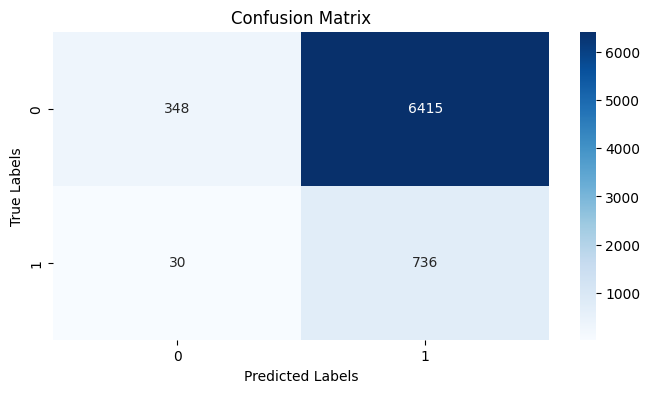

In [22]:
best_individual = genetic_algorithm.population[0]
test = X_test.copy()
test= np.array(test)
test[:,0] = best_individual[0]
test[:,4] = best_individual[4]
test[:,5] = best_individual[5]
test[:,6] = best_individual[6]

test = torch.tensor(test, dtype=torch.float32).to(device)
predictions = model(test.to(device))
predictions = torch.argmax(predictions, dim=1)
predictions = predictions.cpu().numpy()
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(8,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## White Box attack

In [44]:
import torch
import torch.nn as nn
import torch.optim as optim

# Example model
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 5)  # First layer
        self.fc2 = nn.Linear(5, 1)   # Second layer
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize model
model = SimpleModel()

# Example input and target
input_data = torch.randn(1, 10)  # Random input (1 sample, 10 features)
target = torch.randn(1, 1)       # Random target

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Forward pass
output = model(input_data)

# Compute loss
loss = criterion(output, target)

# Zero gradients before backward pass
optimizer.zero_grad()

# Backward pass to calculate gradients
loss.backward()

# Get gradients of the first layer
gradients_fc1 = model.fc1.weight.grad

# Print gradients of the first layer
print(gradients_fc1)


AttributeError: 'Linear' object has no attribute 'grad'

TypeError: 'NoneType' object is not callable

In [25]:
model[0].weight

TypeError: 'Model' object is not subscriptable

# 2. Prove that your model can be more robust to adversarial examples

Demonstrate that your model maintains high accuracy when subjected to adversarial examples. Provide empirical evidence of robustness by evaluating performance under adversarial attacks.

What Will Be Valued:
- Effective adversarial attack methods and proper defense mechanisms.
- Clear evaluation metrics comparing standard vs. adversarial performance.
- Well-documented methodology and reproducibility of results.

# 3. Try to attack this model

You will be given the anonymous model `android_permission_model.onnx`, previously trained on the provided dataset. 
Analyze the model’s weaknesses by testing different black-box attack strategies.

What Will Be Valued:
- Use of diverse adversarial attack techniques.
- Quantitative analysis of attack effectiveness with relevant metrics.
- Clear documentation of the attack process and reproducibility.

Below, you can find an example on model loading and inference. The model expects every column in the dataset except for `sha256`, `timestamp` and `unused_permissions`.
The model is loaded in an [onnx runtime](https://onnxruntime.ai/docs/api/python/api_summary.html). 

In [3]:


DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
model_path = 'android_permission_model.onnx'

# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

# features and target separation + train/test split
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Example inference function using [sess.run()](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession.run):

In [21]:
def onnx_inference(model_path, test_data):
    """
    Function to load and make predictions with an ONNX model
    """
    # open ONNX inference session
    sess = rt.InferenceSession(model_path)
    
    # input and output names
    input_name = sess.get_inputs()[0].name
    output_names = [output.name for output in sess.get_outputs()]
    
    # send inputs to the model and obtain predictions
    results = sess.run(output_names, {input_name: test_data.astype(np.float32)})

    return results[0]       # results[0] are discrete predicted labels, while results[1] are probabilities

In [22]:
# try and load the model
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    # small sample to test if it works
    test_sample = X_test.iloc[:5].values
    onnx_predictions = onnx_inference(model_path, test_sample)
    
    if onnx_predictions is not None:
        print("\nONNX Model Predictions (sample):")
        print(onnx_predictions)
        
        # compare with actual labels
        actual_labels = y_test.iloc[:5].values
        print("\nActual labels:")
        print(actual_labels)
    
    # full test set now
    print("\nONNX Model Predictions (full test set):")
    full_predictions = onnx_inference(model_path, X_test.values)

    try:
        print(f"Accuracy: {accuracy_score(y_test, full_predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, full_predictions))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, full_predictions))
    except Exception as e:
        print(f"Error during ONNX prediction: {e}")


ONNX Model Predictions (sample):
[1 0 0 0 1]

Actual labels:
[1 0 0 0 0]

ONNX Model Predictions (full test set):
Accuracy: 0.9815

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16943
           1       0.86      0.97      0.91      1880

    accuracy                           0.98     18823
   macro avg       0.93      0.98      0.95     18823
weighted avg       0.98      0.98      0.98     18823


Confusion Matrix:
[[16642   301]
 [   48  1832]]
